# PRMT-2318 Investigate Large Messaging Errors for Vision in July and August

## Context
We saw a large increase in Large messaging errors in July where Vision was the sender and receiver in July, with a sharp drop off at the end (when they rolled out large messaging accross all their practice). 

So we wanted to investigate large messaging errors in August (15 days), as we expect all the Vision practices to be large message compliant, irrespective of sending/recieving.

In [114]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime

In [115]:
transfer_files = [
    "s3://prm-gp2gp-notebook-data-prod/PRMT-2324-2-weeks-august-data/transfers/v4/2021/8/transfers.parquet"
]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_files
))

In [116]:
# filter data to just include the first 2 weeks (15 days) of august
date_filter_bool = transfers_raw["date_requested"] < datetime(2021, 8, 16)
transfers_half_august = transfers_raw[date_filter_bool]

In [117]:
transfers = transfers_half_august.copy()
transfers["status"] = transfers["status"].str.replace("_", " ").str.title()

In [118]:
asid_lookup_file_location = "s3://prm-gp2gp-asid-lookup-prod/"
asid_lookup_files = [
    "2021/8/asidLookup.csv.gz"    
]
asid_lookup_input_files = [asid_lookup_file_location + f for f in asid_lookup_files]
asid_lookup = pd.concat((
    pd.read_csv(f)
    for f in asid_lookup_input_files
)).drop_duplicates()
lookup = asid_lookup[["ASID", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

## Vision as a sender

In [119]:
vision_sender_bool = transfers["sending_supplier"]=="Vision"
has_23_error_bool = transfers["sender_error_codes"].apply(lambda error_codes: 23 in error_codes)
vision_transfers_with_error_23 = transfers[vision_sender_bool & has_23_error_bool].copy()

In [120]:
vision_transfers_with_error_23["date"] = vision_transfers_with_error_23["date_requested"].dt.date

(array([18842., 18844., 18846., 18848., 18850.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

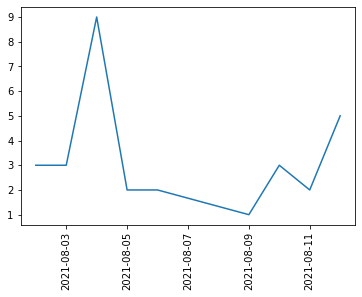

In [121]:
sender_grouped_by_date = vision_transfers_with_error_23.groupby(by="date").agg({"conversation_id": "count"}).reset_index()
plt.plot(sender_grouped_by_date['date'], sender_grouped_by_date['conversation_id'])
plt.xticks(rotation='vertical')

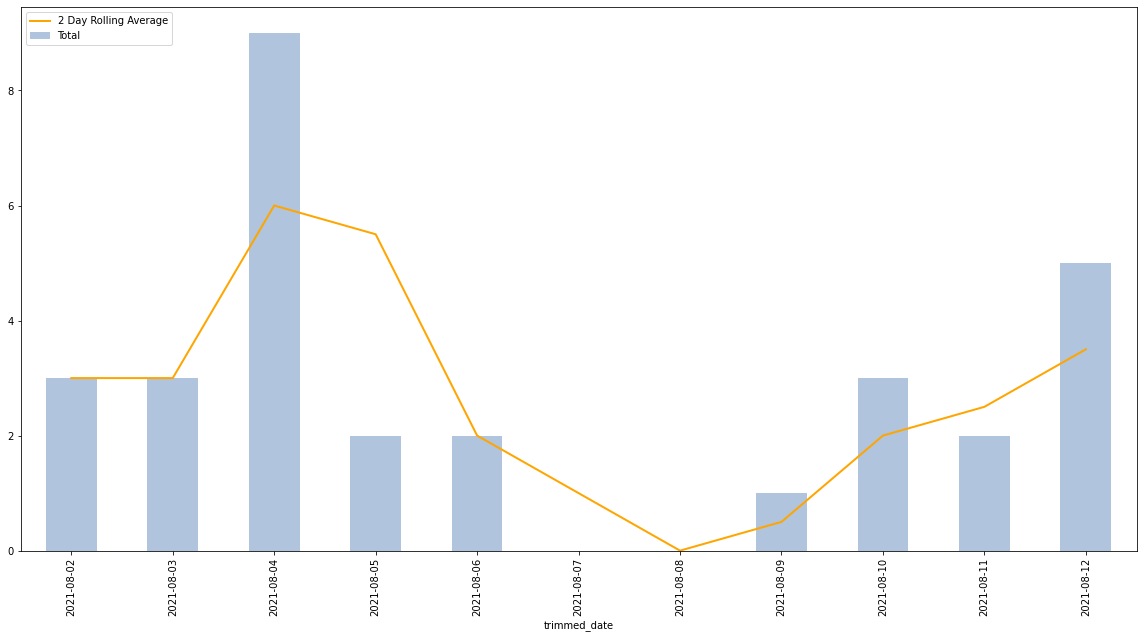

In [122]:
day_range = pd.date_range(sender_grouped_by_date.date.min(), sender_grouped_by_date.date.max(), freq='D')
sender_full_date_range=sender_grouped_by_date.set_index('date').reindex(day_range).fillna(0).rename_axis('date').reset_index() 

# add rolling average 
sender_full_date_range["rolling avg"] = sender_full_date_range.conversation_id.rolling(2, min_periods=1).mean()

sender_full_date_range['trimmed_date'] = sender_full_date_range['date'].dt.date

sender_full_date_range.plot.bar(x='trimmed_date', y='conversation_id', figsize=(20,10), label='Total', color='lightsteelblue')
plt.plot(sender_full_date_range['rolling avg'], label='2 Day Rolling Average', color='orange', linewidth=2)
plt.legend(loc=2)


In [123]:
total_of_vision_practices_with_with_error_23 = vision_transfers_with_error_23.groupby(by=["sending_practice_name", "sending_ods_code"]).agg({"conversation_id": "count"}).rename({'conversation_id':'total'},axis=1)
total_of_vision_practices_with_with_error_23.sort_values(by="total", ascending=False)

,,total
sending_practice_name,sending_ods_code,
THE TRINITY MEDICAL PRACTICE,F81751,6
WIMBLEDON VILLAGE PRACTICE,H85027,4
WAYSIDE MEDICAL PRACTICE,H81046,2
THE MOSSLANDS MEDICAL PRACTICE,P87610,2
THE HAWTHORNS SURGERY,M85175,2
BELLEGROVE SURGERY,G83009,1
PEMBROKE SURGERY,K81100,1
SUTTON ROAD SURGERY,M85115,1
PLUMBRIDGE MEDICAL CENTRE,G83641,1


## Vision as a requester

In [124]:
vision_requester_bool = transfers["requesting_supplier"]=="Vision"
has_14_error_bool = transfers["sender_error_codes"].apply(lambda error_codes: 14 in error_codes)
vision_transfers_with_error_14 = transfers[vision_requester_bool & has_14_error_bool].copy()

In [125]:
vision_transfers_with_error_14["date"] = vision_transfers_with_error_14["date_requested"].dt.date

(array([18842., 18844., 18846., 18848., 18850., 18852.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

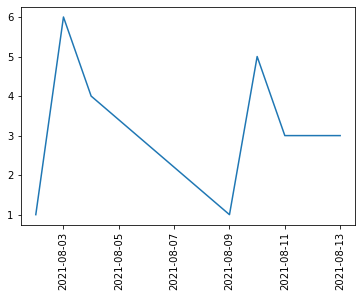

In [126]:
requester_grouped_by_date = vision_transfers_with_error_14.groupby(by="date").agg({"conversation_id": "count"}).reset_index()
plt.plot(requester_grouped_by_date['date'], requester_grouped_by_date['conversation_id'])
plt.xticks(rotation='vertical')

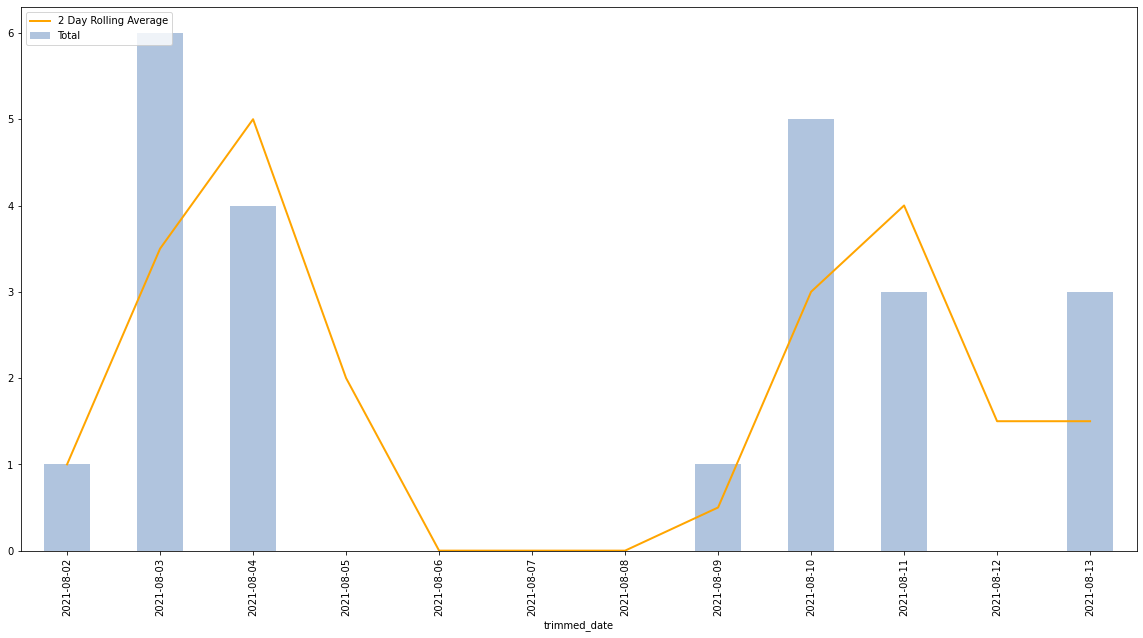

In [127]:
day_range= pd.date_range(requester_grouped_by_date.date.min(), requester_grouped_by_date.date.max(), freq='D')
requester_full_date_range=requester_grouped_by_date.set_index('date').reindex(day_range).fillna(0).rename_axis('date').reset_index() 

# add rolling average 
requester_full_date_range["rolling avg"] = requester_full_date_range.conversation_id.rolling(2, min_periods=1).mean()

requester_full_date_range['date'] = pd.to_datetime(requester_full_date_range['date'])
requester_full_date_range['trimmed_date'] = requester_full_date_range['date'].dt.date

requester_full_date_range.plot.bar(x='trimmed_date', y='conversation_id', figsize=(20,10), label='Total', color='lightsteelblue')
plt.plot(requester_full_date_range['rolling avg'], label='2 Day Rolling Average', color='orange', linewidth=2)
plt.legend(loc=2)


In [128]:
total_of_vision_practices_with_with_error_14 = vision_transfers_with_error_14.groupby(by=["requesting_practice_name", "requesting_ods_code"]).agg({"conversation_id": "count"}).rename({'conversation_id':'total'},axis=1)
total_of_vision_practices_with_with_error_14.sort_values(by="total", ascending=False)

,,total
requesting_practice_name,requesting_ods_code,
WIMBLEDON VILLAGE PRACTICE,H85027,11
THE TRINITY MEDICAL PRACTICE,F81751,4
WAYSIDE MEDICAL PRACTICE,H81046,4
BLAKENEY SURGERY,L84029,2
1/MONTON MEDICAL PRACTICE,P87620,1
FAIRFAX GROUP PRACTICE,P83001,1
